In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'numbers_gen_8_attention'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
#sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
#sample_data = sample_data[sample_data['class'] != 'MANUAL']

sample_data =  sample_data[sample_data['class'] == 'NUMBERS']

print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 448170,  (dropped rows: 9470022)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NUMBERS']
1


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
%%timeit
balanced_data_sample_row()

108 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
NUMBERS    20000
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                          498487
token_id                                  3
class                               NUMBERS
before                           October 10
after                         october tenth
class_org                              DATE
a_word_ind                      [61, 93, 0]
sentence       the independent , <SAMPLE> .
Name: 297436, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NUMBERS : 13 October 2008 -> the thirteenth of october two thousand eight <EOS> [11, 100, 12, 61, 5, 8, 16, 0]
mccarthy , caroline ( <SAMPLE> ) .
torch.Size([1, 16, 104])


In [17]:
%%timeit
get_random_sample()

154 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [19]:
MAX_ATTENTION_LENGTH = 20

### Encoder

In [91]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)
        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [98]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
list(encoder_output.data.cpu().numpy()) == list(encoder_outputs[len(tmp)].data.cpu().numpy())

'1 GHz'

torch.Size([384])

torch.Size([20, 384])

True

### Decoder

In [99]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)

        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (embedding): Embedding(1351, 384)
  (attn): Linear (768 -> 20)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

In [100]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [101]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

Variable containing:
 725
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

nukupuu


# Training etc

### Accuracy

In [102]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        ASDFFDSA
        #INTPUT
        #INTPUT
        decoder_intput = torch.LongTensor([word_index])
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu',
 'nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu',
 'the twelfth of june twenty ten',
 ('12 June 2010',
  [11, 95, 12, 68, 6, 44, 0],
  'NUMBERS',
  '<SAMPLE> five hours from paris film . com .'))

In [103]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

2004           => nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu || [5, 8, 19, 0] 
                  since <SAMPLE> , standard telephone numbers in rostov on don have been seven digits in length .
2010           => nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu nukupuu || [6, 44, 0] 
                  dear alice competed at the <SAMPLE> moscow film festival .


### Training

In [104]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
        
                
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        # HERE WE HAVE MISTAKE
        ASDFFDSA
        #INTPUT
        #INTPUT
        decoder_intput = torch.LongTensor([word_index])
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [110]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0: # or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [111]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/numbers_gen_8_attention_2


In [112]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   4.770   |   6.55: 7 -> <EOS> (✗: [18, 0]) (forcing)
    18  36% (   0m 0s)   4.890   |   6.58: 10 September 1960 -> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: [11, 93, 12, 64, 7, 39, 0]) (forcing)
    27  54% (   0m 0s)   4.869   |   5.58: 10 -> <EOS> (✗: [44, 0]) (forcing)
    36  72% (   0m 0s)   4.824   |   5.77: May 3, 2012 -> <EOS> <EOS> <EOS> <EOS> (✗: [66, 76, 6, 47, 0]) (forcing)
    45  90% (   0m 0s)   4.491   |   1.25: June 15, 1887 ->  (✗: [68, 91, 40, 27, 18, 0]) 


In [113]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 8s)   2.693   |   0.84: 1993 -> nineteen (✗: [9, 8, 15, 10, 23, 13, 0]) 


In [114]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 18s)   2.547   |   6.32: 11.4/km² -> the twenty of <EOS> <EOS> <EOS> (✗: [48, 46, 19, 112, 106, 89, 0]) (forcing)
  3000  22% (  0m 38s)   2.289   |   1.04: 2003 -> two thousand (✗: [5, 8, 13, 0]) 
  4000  33% (  0m 57s)   2.196   |   0.94: 2009 -> two thousand (✗: [5, 8, 15, 0]) 
  5000  44% (  1m 17s)   2.140   |   1.16: 2 -> two (✓) 
  6000  56% (  1m 36s)   2.061   |   1.75: 6 -> one (✗: [20, 0]) 
  7000  67% (  1m 55s)   2.045   |   2.29: August 28, 2004 -> february twenty two thousand (✗: [70, 6, 80, 5, 8, 19, 0]) 
  8000  78% (  2m 14s)   1.966   |   0.73: 1997 -> nineteen ninety nine (✗: [7, 23, 18, 0]) 
  9000  89% (  2m 33s)   1.954   |   1.37: 21 June 2007 -> the twenty of of twenty twenty thousand <EOS> (✗: [11, 6, 56, 12, 68, 5, 8, 18, 0]) (forcing)
 10000 100% (  2m 53s)   1.923   |   2.14: 740 -> one hundred (✗: [18, 10, 41, 0]) 


In [122]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 27s)   0.972   |   0.19: 1968 -> nineteen sixty eight (✓) 
 30000  22% (  6m 49s)   0.579   |   0.01: 26 -> twenty six (✓) (forcing)
 40000  33% ( 10m 20s)   0.532   |   0.67: 16 February 1952 -> the eighteenth of october nineteen fifty five (✗: [11, 98, 12, 72, 7, 38, 5, 0]) 
 50000  44% ( 13m 47s)   0.448   |   0.59: December 6, 2012 -> december twelfth twenty twelve (✗: [65, 79, 6, 47, 0]) 
Saved model to data/models/numbers_gen_8_attention_2/50000_(EncoderRNN/DecoderRNN)
Accuracy: 67.54% (    6754/   10000)
 60000  56% ( 18m 26s)   0.451   |   0.00: 2004 -> two thousand four (✓) (forcing)
 70000  67% ( 21m 56s)   0.312   |   0.93: December 8, 1903 -> december sixth nineteen thirty three (✗: [65, 80, 7, 25, 13, 0]) (forcing)
 80000  78% ( 25m 52s)   0.394   |   0.01: 78 -> seventy eight (✓) 
 90000  89% ( 29m 46s)   0.288   |   0.09: 1128 -> eleven twenty eight (✓) (forcing)
100000 100% ( 33m 49s)   0.251   |   0.01: 35 -> thirty five (✓) 
Saved model to data/model

In [124]:
print_local_wrong_predictions()

24 March 2015  => the twenty fifth of march twenty fifteen || [11, 6, 77, 12, 62, 6, 51, 0] 
                  guest services , inc retrieved <SAMPLE> .
230,000        => two hundred fifty thousand thousand || [5, 10, 34, 8, 0] 
                  as of 2008 , the circulation is about <SAMPLE> .
2008-11-03     => the third of february two thousand eight || [11, 76, 12, 69, 5, 8, 16, 0] 
                  margot williams ( <SAMPLE> ) .
1315           => thirteen thirteen || [49, 51, 0] 
                  ralph was possessed of land in three oxfordshire townships in <SAMPLE> , viz .
VIII           => the seventh    || [11, 80, 0] 
                  henry <SAMPLE> and the court : art , politics and performance , co edited with thomas betteridge , ashgate , 2013 .
1984           => nineteen eighty four || [9, 8, 15, 10, 27, 19, 0] 
                  during 1983 - <SAMPLE> butenas worked for the soviet embassy in afghanistan .
11g            => one hundred a  || [48, 288, 0] 
               

In [159]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000  10% (  3m 49s)   0.271   |   0.01: 457 -> four hundred fifty seven (✓) (forcing)
120000  20% (  7m 34s)   0.254   |   0.04: 1983 -> nineteen eighty three (✓) 
130000  30% ( 11m 12s)   0.248   |   0.04: October 13, 1942 -> october thirteenth nineteen forty two (✓) (forcing)
140000  40% ( 14m 49s)   0.228   |   0.01: 63 -> sixty three (✓) 
150000  50% ( 18m 28s)   0.208   |   0.00: 2004 -> two thousand four (✓) 
Saved model to data/models/numbers_gen_8_attention_2/150000_(EncoderRNN/DecoderRNN)
Accuracy: 86.94% (    8694/   10000)


KeyboardInterrupt: 

In [169]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

168017  20% (  3m 31s)   0.215   |   0.00: 380 -> three hundred eighty (✓) (forcing)
178017  40% (   7m 4s)   0.201   |   0.02: 18 -> eighteen (✓) (forcing)
188017  60% ( 10m 35s)   0.186   |   0.01: 1991 -> nineteen ninety one (✓) 
198017  80% (  14m 8s)   0.156   |   0.02: 18 March 1945 -> the eighteenth of march nineteen forty five (✓) 
Saved model to data/models/numbers_gen_8_attention_2/200000_(EncoderRNN/DecoderRNN)
Accuracy: 85.33% (    8533/   10000)
208017 100% (  19m 1s)   0.190   |   0.00: October 30, 2010 -> october thirtieth twenty ten (✓) (forcing)


In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

input:   2,600 ft
output:  ['two', 'thousand', 'six', 'hundred', 'six', 'hundred']
target:    two thousand six hundred feet


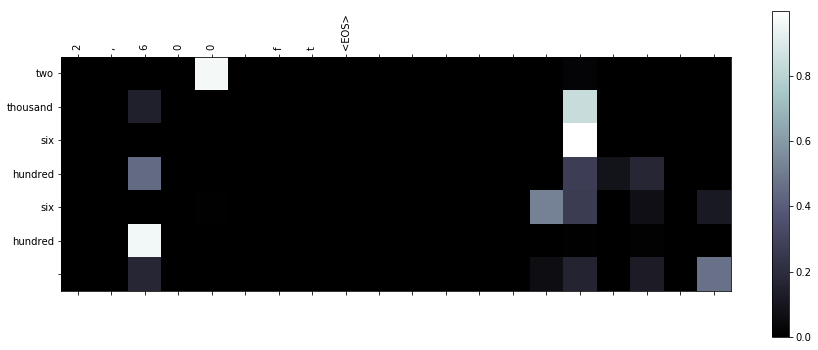

In [174]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    #output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input: ', [words_after_common[w] for w in sample[1]])
    print(output)

    showAttention(input_sentence, output_words, attentions)

    
output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
print('input:  ', sample[0])
print('output: ', decoded_output)
print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

debug_show_attention(list(sample[0]), decoded_output, attns)

#debug_eval_sample_show_attention()
#tmp = [r/sum(r) for r in attns]
#plt.matshow(tmp)
#plt.matshow(attns)


input:   92.0
output:  ['ninety', 'two', 'point', 'zero']
target:    ninety two point zero


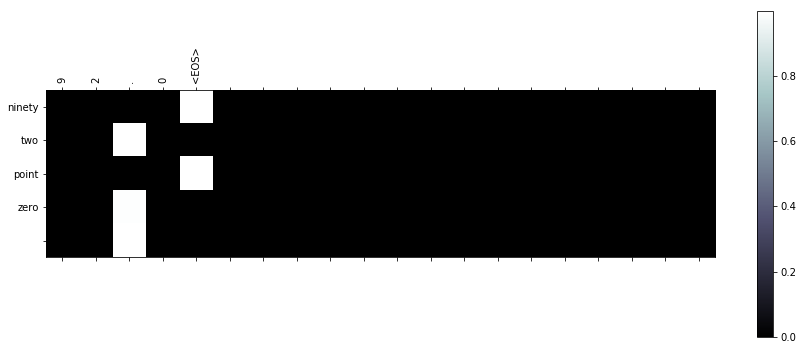

In [158]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    #output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input: ', [words_after_common[w] for w in sample[1]])
    print(output)

    showAttention(input_sentence, output_words, attentions)

    
output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
print('input:  ', sample[0])
print('output: ', decoded_output)
print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

debug_show_attention(list(sample[0]), decoded_output, attns)

#debug_eval_sample_show_attention()
#tmp = [r/sum(r) for r in attns]
#plt.matshow(tmp)
#plt.matshow(attns)
